In [ ]:
import os

from src.models.auto_encoder import build_encoder, build_decoder, AutoEncoder

os.environ["KERAS_BACKEND"] = "torch"

from src.data.preprocessing import preprocess

from src.data.load_data import load_sample_train_test
from src.utils.misc import init_notebook

In [133]:
init_notebook()

Generator(PCG64) at 0x19AADF66A40

In [134]:
x_train, x_test, y_train, y_test = load_sample_train_test()

In [135]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [136]:
x_train.shape

(2392, 784)

In [137]:
e = build_encoder()
e.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_43 (Reshape)            │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 26)             │        20,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,354 (99.04 KB)

 Trainable params: 25,354 (99.04 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
d = build_decoder()
d.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1568)           │        42,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_44 (Reshape)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 14, 14, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 28, 28, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_39             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_45 (Reshape)            │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,889 (202.69 KB)

 Trainable params: 51,889 (202.69 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
auto_encoder = AutoEncoder()

In [140]:
auto_encoder.fit(x_train)

Epoch 1/10
 8/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2250

C:\Users\AB2-PC\Documents\GitHub\ab2\recognize-handwritten-letters\.venv\lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1748 - val_loss: 0.0755
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0736 - val_loss: 0.0731
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0720 - val_loss: 0.0706
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0670 - val_loss: 0.0524
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0460 - val_loss: 0.0336
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0307 - val_loss: 0.0255
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0237 - val_loss: 0.0223
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0208 - val_loss: 0.0200
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0161 - val_loss: 0.0171


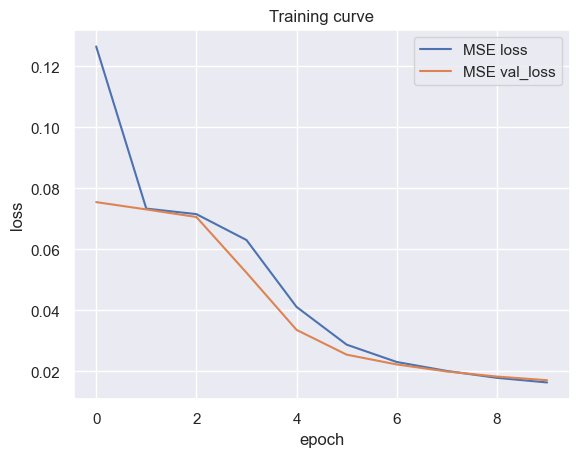

In [143]:
_ = auto_encoder.plot_training_curve()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


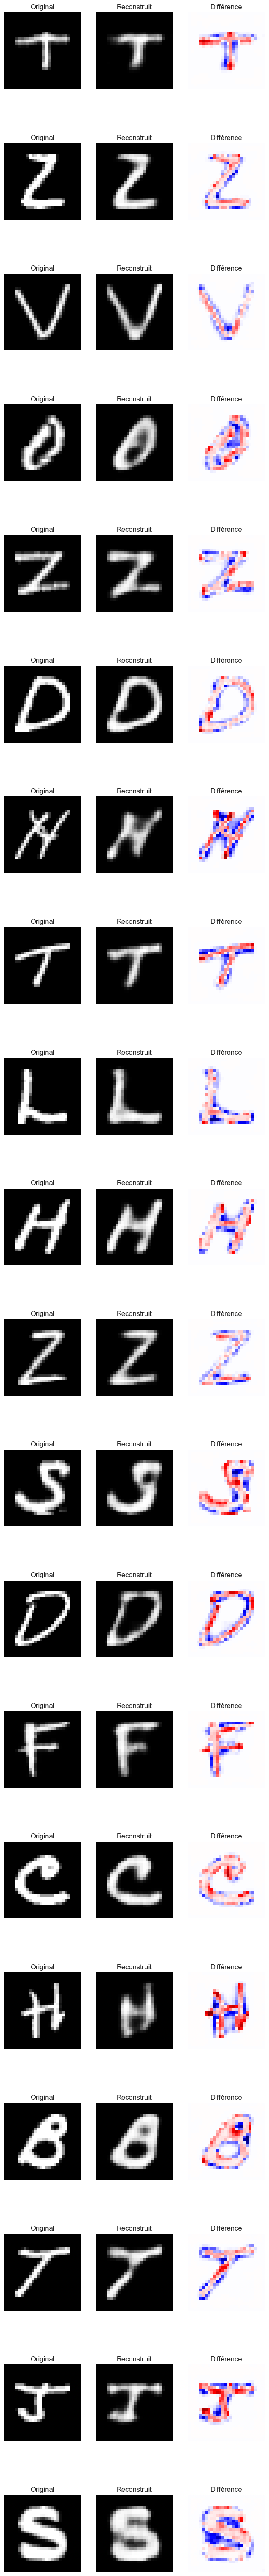

In [144]:
auto_encoder.visualize(x_test)